<a href="https://colab.research.google.com/github/hwangswan/movie-reviews-sa/blob/main/MovieReviewSA_multinomialNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Review Sentiment Analysis

(using Naive Bayes classifier)



In [1]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from wordcloud import WordCloud
from wordcloud.color_from_image import ImageColorGenerator
from tqdm import tqdm

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import tensorflow as tf

## Importing data

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
zip_data = '/gdrive/MyDrive/Colab Notebooks/sentiment-analysis-on-movie-reviews.zip'

with zipfile.ZipFile(zip_data, 'r') as f:
    f.extractall('/content/data/')

In [5]:
test_zip = '/content/data/test.tsv.zip'

with zipfile.ZipFile(test_zip, 'r') as f:
    f.extractall('/content/data/')

In [6]:
train_zip = '/content/data/train.tsv.zip'

with zipfile.ZipFile(train_zip, 'r') as f:
    f.extractall('/content/data/')

## First look at the data

In [7]:
train_tsv = '/content/data/train.tsv'
test_tsv = '/content/data/test.tsv'

In [8]:
train_df = pd.read_csv(train_tsv, sep = '\t')

In [9]:
train_df.shape

(156060, 4)

In [10]:
train_df.iloc[0]

PhraseId                                                      1
SentenceId                                                    1
Phrase        A series of escapades demonstrating the adage ...
Sentiment                                                     1
Name: 0, dtype: object

Drop PhraseId and SentenceId, since I guess it's useless btw

In [11]:
train_df = train_df.drop('PhraseId', axis = 1)
train_df = train_df.drop('SentenceId', axis = 1)

In [12]:
train_df

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2
...,...,...
156055,Hearst 's,2
156056,forced avuncular chortles,1
156057,avuncular chortles,3
156058,avuncular,2


Plotting sentiments

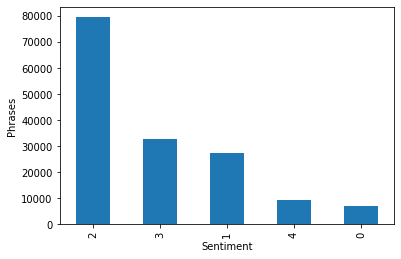

In [13]:
counts = train_df['Sentiment'].value_counts()
counts.plot.bar()
plt.xlabel('Sentiment')
plt.ylabel('Phrases')
plt.show()

## Preprocessing
Steps of preprocessing include:
- Lowercasing the sentence
- Remove special characters

In [14]:
# Get stopwords list
stopword_file = '/gdrive/MyDrive/Colab Notebooks/stopwords.txt'

stopwords = []

with open(stopword_file, 'r+') as f:
    for line in f:
        stopwords.append(line.rstrip().lower())

In [15]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [16]:
# Preprocessing data
def preprocess(sentence):
    sentence = sentence.lower()
    sentence = sentence.replace('\'s', 'is')
    sentence = sentence.replace('wo n\'t', 'will not')
    sentence = sentence.replace('n\'t', 'not')
    sentence = sentence.replace('/', ' ')
    sentence = sentence.replace('\\', ' ')
    sentence = sentence.replace(',', ' ')
    sentence = sentence.replace('.', ' ')
    sentence = sentence.replace('`', ' ')
    sentence = sentence.replace('"', ' ')
    sentence = sentence.replace('\'', ' ')
    sentence = sentence.replace('-lrb-', ' ')
    sentence = sentence.replace('-rrb-', ' ')
    sentence = sentence.replace(' - ', ' ')
    sentence = sentence.replace(' -- ', ' ')
    return sentence.strip()

# Tokenize (splitting by space)
def tokenizer(sentence):
    raw_tokens = sentence.lower().split(' ')
    return list(filter(None, raw_tokens))

In [17]:
sentence = 'Not exaggerated enough to be a parody of gross-out flicks , college flicks , or even flicks in general .'
print(preprocess(sentence))
print(tokenizer(preprocess(sentence)))

not exaggerated enough to be a parody of gross-out flicks   college flicks   or even flicks in general
['not', 'exaggerated', 'enough', 'to', 'be', 'a', 'parody', 'of', 'gross-out', 'flicks', 'college', 'flicks', 'or', 'even', 'flicks', 'in', 'general']


In [18]:
# Build a vectorizer
vectorizer = CountVectorizer(
    tokenizer=tokenizer,
    stop_words=stopwords
)

In [19]:
# Splitting train and test

train_df

X_train, X_test, y_train, y_test = train_test_split(train_df['Phrase'], train_df['Sentiment'], test_size = 0.33, random_state = 42)

In [20]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (104560,)
X_test shape: (51500,)


In [21]:
# Creating sentence arrays
train_sentences, test_sentences = [], []

for s in tqdm(X_train):
    train_sentences.append(preprocess(s))

for s in tqdm(X_test):
    test_sentences.append(preprocess(s))

100%|██████████| 51500/51500 [00:00<00:00, 109143.66it/s]


In [22]:
print(X_train.shape, len(train_sentences))
print(X_test.shape, len(test_sentences))

(104560,) 104560
(51500,) 51500


Plotting the wordcloud

In [23]:

# Plotting the wordcloud
def plot_wordcloud(text, stopwords, mask = None, max_words = 200, max_font_size = 100, 
                   figure_size = (24.0, 16.0), title = None, title_size = 40, image_color = False):
    wordcloud = WordCloud(
        background_color = 'black',
        stopwords = stopwords,
        max_words = max_words,
        max_font_size = max_font_size,
        random_state = 42,
        width = 800,
        height = 400,
        mask = mask)
    
    wordcloud.generate(' '.join(text))

    plt.figure(figsize = figure_size)
    
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func = image_colors), interpolation = 'bilinear')

        plt.title(title, fontdict = {
            'size' : title_size,
            'verticalalignment' : 'bottom'
        })
    
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict = {
            'size' : title_size,
            'color' : 'black',
            'verticalalignment' : 'bottom'
        })

    plt.axis('off')
    plt.tight_layout()

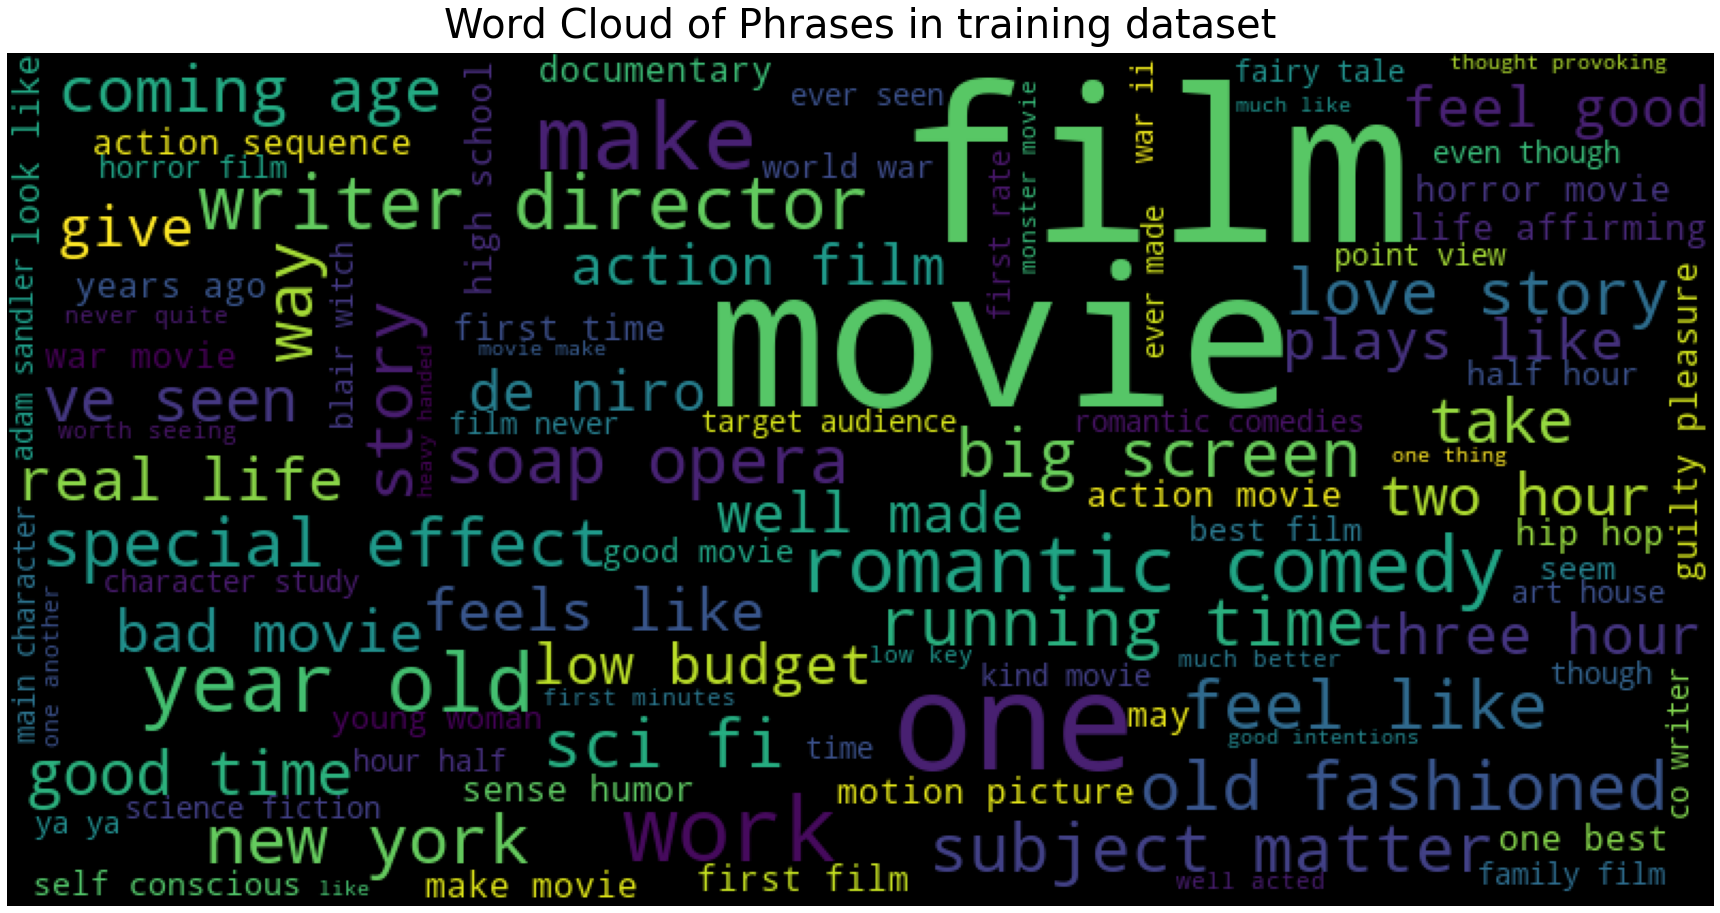

In [24]:
plot_wordcloud(
    [preprocess(s) for s in train_df['Phrase'].values], max_words = 100,
     stopwords = stopwords, title = 'Word Cloud of Phrases in training dataset')

## Using MultinomialNB to create a model and fitting it with training data.

In [25]:
X = vectorizer.fit_transform(train_sentences)
y = y_train

model = MultinomialNB()
model.fit(X, y)

MultinomialNB()

In [26]:
# Score

X_test__ = vectorizer.transform(test_sentences)

print(model.score(X_test__, y_test))

0.6066601941747573


In [27]:
# Printing confusion matrix

predictions = [pred for pred in model.predict(X_test__)]

confusion_matrix = tf.math.confusion_matrix(
    labels = y_test, predictions = predictions
)

confusion_matrix

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[  640,  1155,   476,    64,     6],
       [  534,  3807,  4153,   528,    39],
       [  185,  2352, 20330,  2927,   204],
       [   32,   389,  4281,  5577,   711],
       [    2,    44,   480,  1695,   889]], dtype=int32)>

Text(69.0, 0.5, 'True')

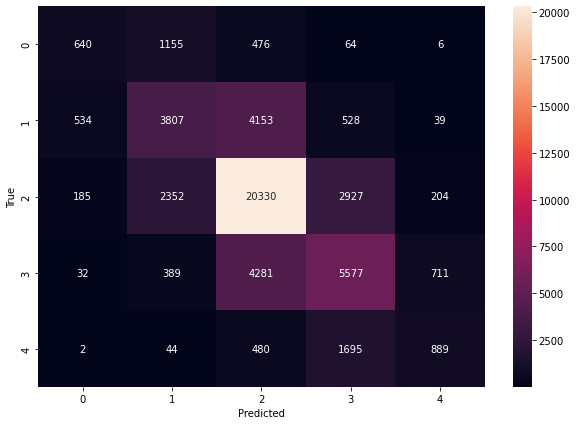

In [28]:
plt.figure(figsize = (10, 7))
sb.heatmap(confusion_matrix, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('True')

## Create submission

Re-train model with full training data

In [29]:
X_submit_sentences = []

for s in train_df['Phrase']:
    X_submit_sentences.append(preprocess(s))


X_submit_model = vectorizer.fit_transform(X_submit_sentences)

y_submit_model = train_df['Sentiment']

In [30]:
submission_model = MultinomialNB()
submission_model.fit(X_submit_model, y_submit_model)

MultinomialNB()

Now we have the submission model, let's predict and write predictions to submission file.

In [31]:
test_df = pd.read_csv(test_tsv, sep = '\t')

In [32]:
list_phrase_ids = test_df['PhraseId']
list_phrases = test_df['Phrase']

In [33]:
sentiments = []

for p in tqdm(list_phrases):
    predict_ = submission_model.predict(vectorizer.transform([preprocess(p)]))
    sentiments.append(predict_[0])

100%|██████████| 66292/66292 [00:40<00:00, 1621.24it/s]


In [34]:
pd.DataFrame({
    'PhraseId' : list_phrase_ids,
    'Sentiment' : sentiments
}).to_csv('submission.csv', index = False)